# Cargar paquetes

Cargamos los paquetes de python que vamos a utilizar.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.signal import find_peaks
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time

# Leer archivos

Leemos los tres archivos de que disponemos. Para ilustrar los resultados de cada de una de las funciones utilizaremos unicamente uno de ellos (TrozoC).

In [2]:
trozoC = pd.read_csv("TrozoC.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")

In [3]:
trozoG = pd.read_csv("TrozoG.txt", names=["LP", "VD", "Time"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")

In [4]:
trozoR = pd.read_csv("TrozoR.txt", names=["LP", "VD"], 
                     delimiter="\t", skiprows = range(3), 
                     index_col=False, decimal=",")

Mostramos los primeros 5 elementos de trozoC y comprobamos que las opciones elegidas en la función `read_csv` de `Pandas` consiguen leerel archivo `.txt` correctamente.

In [5]:
trozoC.head()

,LP,VD
0,0.004883,0.015259
1,0.001526,0.024109
2,-0.010681,0.031128
3,-0.022278,0.041809
4,-0.028076,0.045471


Lo primero que vamos a hacer, es establecer un umbral a partir del cual se considerará que existe un spike en la señal.

# Establecer umbral

Para la elección del umbral se ha seguido un procedimiento de ensayo-error: como primera estrategia, hemos probado a utilizar el rango intercuartílico de la secuencia, esto es, la distancia entre el valor que deja por encima el 75% de los valores y el que deja el 25%.

El resultado era demasiado conservador, considerando muchos spikes que resultaban no serlo. Aumentar este valor un 50% no solucionó completamente este problema. Por ello, decidimos utilizar lasiguiente fórmula
$$
1.5\times (\mu + 3\times\sigma)
$$
Donde $\mu$ y $\sigma$ con la media y desviación típica de la señal. Este valor corresponde con aquel que concentra aproximadamente el 95% de una distribución normal.

In [6]:
threshold = 1.5*(trozoC[trozoC>=0].mean() + 3*trozoC[trozoC>=0].std())
print(threshold)

LP    0.383358
VD    0.196578
dtype: float64


Applicamos entonces el umbral a la serie tempora, cambiando valores superiores por 1 y el resto por 0.

In [7]:
def filter_with_threshold(df, threshold):
    return (df > threshold).astype(int)

In [8]:
trozoC_t = filter_with_threshold(trozoC, threshold)

El número de elementos que superan el umbral es:

In [9]:
trozoC_t.sum()

LP    125368
VD    161245
dtype: int64

La siguiente función permite pintar simultaneamente la señal original y la transformada con el umbral (escalada para poder compararlas).

In [10]:
def compare_signal_and_transformation(df, df_t, threshold):
    """
    Muestra dos señales `df` y `df_t` que tengan las mismas dimensiones.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(df_t.iloc[:,index])
        xmin, xmax = axs[index].get_xlim()
        axs[index].plot([xmin, xmax], 2*[threshold[index]])

Probamos con los primeros 100 valores.

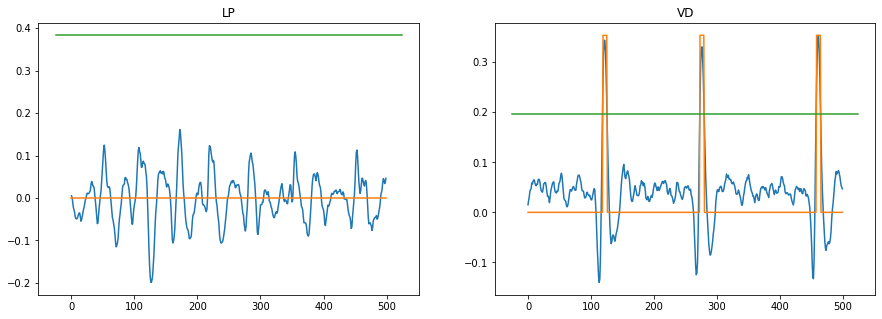

In [11]:
compare_signal_and_transformation(trozoC[0:500], trozoC_t[0:500]*trozoC[0:500].max(), threshold)

Como podemos ver en la primera serie ningún valor a sumerado el umbral en los primeros 100 puntos. sin embargo, en la segunda serie podemos ver 4 spikes correctamente codigicados.

Si cambiamos el intervalo a [2500, 3500] podemos ver spikes de la primera señal.

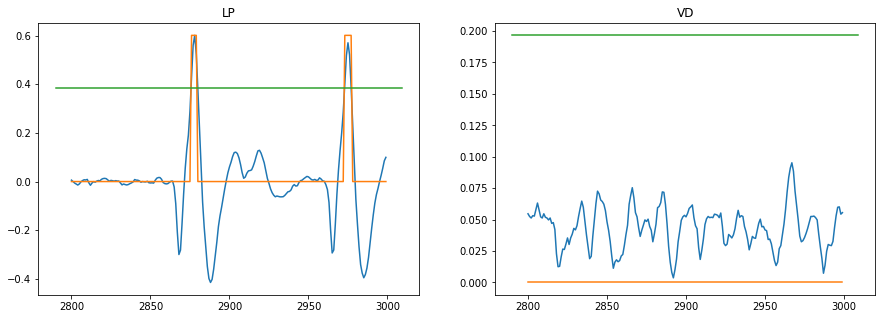

In [12]:
a = 2800
b = 3000
compare_signal_and_transformation(trozoC[a:b], trozoC_t[a:b]*trozoC[a:b].max(), threshold)

# Calcular picos

El siguiente paso es agrupar todos los 1's consecutivos que indican un mismo spike en un único valor. Para ello, utilizamos la función `find_peaks`, la cual computa todos los máximos locales de su argumento, (en caso de existir varios maximos consecutivos con el mismo valor, devuelve solo el valor central). Al utilizarla sobre nuestra serie de 0's y 1's, obtenemos una nueva serie con los puntos medios de las agrupaciones de 1's.

In [13]:
def get_peaks(df):
    """
    Busca los picos correspondientes a cada columna del dataframe utilizando find_peaks. 
    Esta se queda con el valor medio de picos consecutivos.
    """
    # Get number of columns
    cols = df.shape[1] if len(df.shape) > 1 else 1
    # Initialize peaks array
    return np.array([find_peaks(df.iloc[: , index])[0] for index in range(cols)], dtype = object)

El número total de spikes encontrados es:

In [14]:
peaks = get_peaks(trozoC_t)
for i in peaks:
    print(len(i))

31157
22338


EUtilizamos la siguiente función parapintar la serieoriginal junto con los spikes considerados.

In [15]:
def compare_signal_and_peaks(df, peaks):
    """
    Muestra la señal original junto con los picos considerados.
    """
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[:, index])
        axs[index].plot(peaks[index], df.iloc[peaks[index], index], "o")

Observamos los resultados en los primeros 10000 valores, viendo que los spikes visibles han sido correctamente capturados.

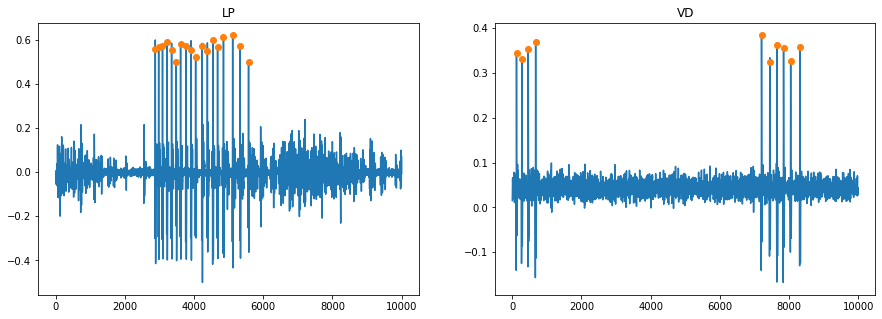

In [16]:
compare_signal_and_peaks(trozoC[0:10000], get_peaks(trozoC_t[0:10000]))

In [17]:
def compare_signal_transformation_and_peaks(df, df_t, peaks, threshold, offset = 0):

    # Get peaks for each column
    plt.plot(df.iloc[:, 0])
    plt.plot(df_t.iloc[:,0])
    xmin, xmax = plt.xlim()
    plt.plot([xmin, xmax], 2*[threshold[0]])
    plt.plot(offset + peaks[0], df.iloc[peaks[0], 0], "o")

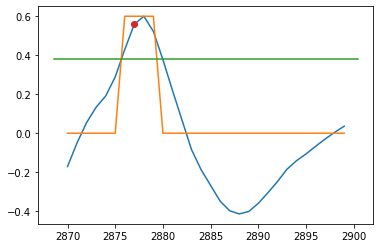

In [18]:
compare_signal_transformation_and_peaks(trozoC[2870:2900], 
                                        trozoC_t[2870:2900]*trozoC[2870:2900].max(), 
                                        get_peaks(trozoC_t[2870:2900]), threshold, offset = 2870)

Pasamos alhora a calcular la distancia mínima entre spikes, de forma que tomaremos un tamaño de bin estrictamente menor.

In [19]:
def min_distance_between_peaks(peaks):
    """
    Calcula la distancia mínima entre picos.
    """
    dist = [peaks[index + 1] - peaks[index] for index in range(len(peaks)-1)]
    return min(dist), dist.index(min(dist)), np.array(dist)

In [20]:
peaks = get_peaks(trozoC_t)
min_dist = np.array([min_distance_between_peaks(a) for a in peaks], dtype = object)
print("Distancia mínima y pico donde se alcanza: ", min_dist[:,0:2])
window = min(min_dist[:,0])
print("Ventana seleccionada: ", window)
min_peak_position = min_dist[:,1]
min_peak_position = [[peaks[idx][min_peak_position[idx]], peaks[idx][min_peak_position[idx]+1]] 
                     for idx in range(len(peaks))]
print("Posiciones de los picos mas cercanos: ", min_peak_position)

Distancia mínima y pico donde se alcanza:  [[23 3570]
 [5 13312]]
Ventana seleccionada:  5
Posiciones de los picos mas cercanos:  [[2142183, 2142206], [12346213, 12346218]]


<AxesSubplot:ylabel='Count'>

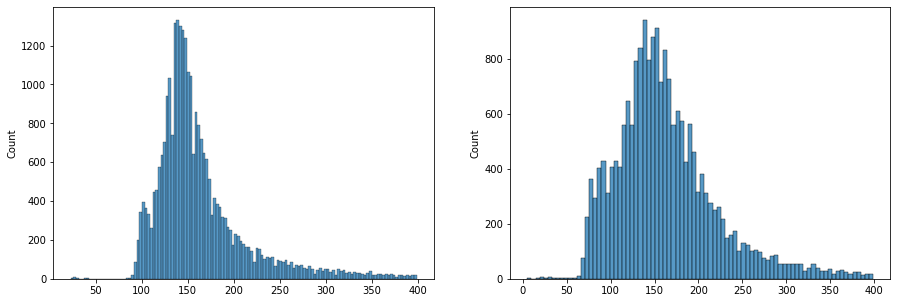

In [21]:
dists = min_dist[:,2]
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(dists[0][dists[0] < 400], ax = axs[0])
sns.histplot(dists[1][dists[1] < 400], ax = axs[1])

Pintamos ahora las series temporales con la rejilla formada por el tamaño de bin escogida junto con los spikes que provocan dicho tamaño de bin.

In [22]:
def plot_window(df, window, peak_position):
    cols = df.shape[1] if len(df.shape) > 1 else 1
    fig, axs = plt.subplots(1, cols, figsize=(15,5))
    # Loop over columns
    for index in range(cols):
        axs[index].set_title(list(df)[index])
        # Get peaks for each column
        axs[index].plot(df.iloc[peak_position[index][0]-50:peak_position[index][1]+50, index], color = "blue")        
        axs[index].plot(peak_position[index][0], df.iloc[peak_position[index][0], index], "o", color = "red")
        axs[index].plot(peak_position[index][1], df.iloc[peak_position[index][1], index], "o", color = "red")
        xlims = [int(np.round(a)) for a in axs[index].get_xlim()]
        offset = int(window* np.round(xlims[0]/window)) 
        axs[index].vlines([ offset + idx for idx in range(0,xlims[1]-xlims[0], window)], *axs[index].get_ylim(), 
                          color = "orange" ) 
        

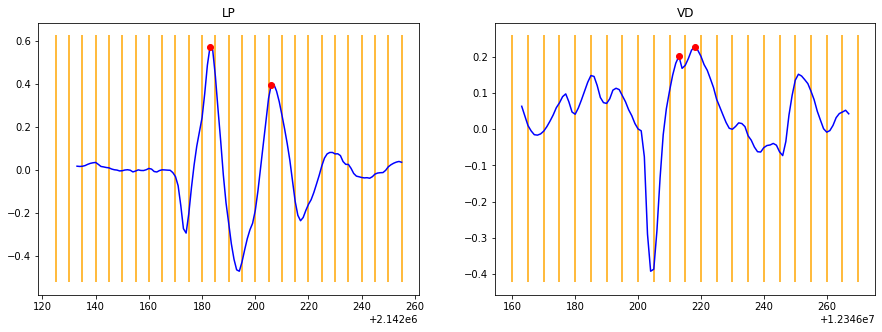

In [23]:
plot_window(trozoC, window, min_peak_position)

## Volvemos a hacer todo con cambio de umbral y borrando elementos en ventana.

Distancia mínima y pico donde se alcanza:  [[65 896]
 [63 12390]]
Ventana seleccionada:  63
Posiciones de los picos mas cercanos:  [[550875, 550940], [12344637, 12344700]]


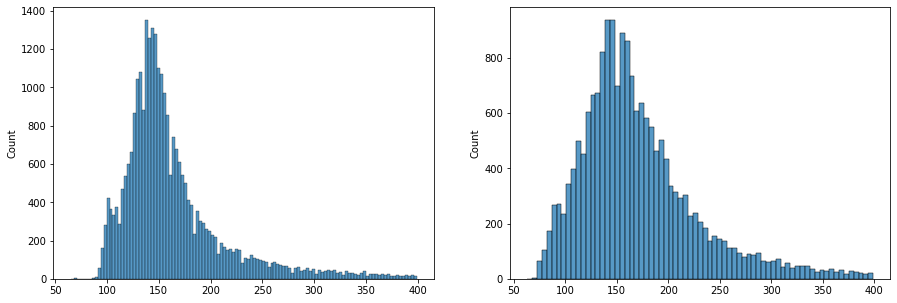

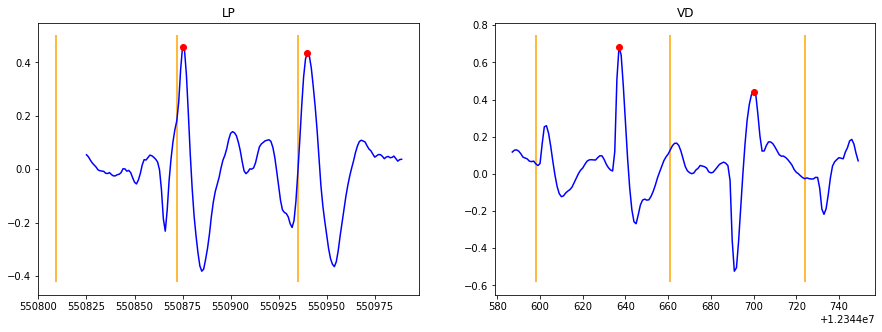

In [24]:
threshold = 1.5*(trozoC[trozoC>=0].mean() + 3*trozoC[trozoC>=0].std())
threshold["VD"] = 0.3 

trozoC_t = filter_with_threshold(trozoC, threshold)
peaks = get_peaks(trozoC_t)
min_dist = np.array([min_distance_between_peaks(a) for a in peaks], dtype = object)
window = min(min_dist[:,0])
dists = min_dist[:,2]

peaks_to_erase = [np.where(a < 60)[0] for a in dists]
peaks_to_erase[0]

peaks = [np.delete(peaks[0], peaks_to_erase[0]), np.delete(peaks[1], peaks_to_erase[1])]
min_dist = np.array([min_distance_between_peaks(a) for a in peaks], dtype = object)
print("Distancia mínima y pico donde se alcanza: ", min_dist[:,0:2])
window = min(min_dist[:,0])
print("Ventana seleccionada: ", window)
min_peak_position = min_dist[:,1]
min_peak_position = [[peaks[idx][min_peak_position[idx]], peaks[idx][min_peak_position[idx]+1]] 
                     for idx in range(len(peaks))]
print("Posiciones de los picos mas cercanos: ", min_peak_position)

dists = min_dist[:,2]
fig, axs = plt.subplots(1, 2, figsize=(15,5))

sns.histplot(dists[0][dists[0] < 400], ax = axs[0])
sns.histplot(dists[1][dists[1] < 400], ax = axs[1])
plot_window(trozoC, window, min_peak_position)

Aplicamos la ventana a la serie temporal, obteniendo series de menor tamaño.

In [25]:
def apply_window(lenght, peaks, window):
    """
    Crea un vector de 0's y 1's representando la existencia de una señal en la 
    ventana prefijada de una serie temporal.
    Argumentos:
    - lenght: Longitud de la serie temporal.
    - peaks: posicion de las señales en la serie temporal.
    - window: tamaño de ventana.
    """
    # Crea vector de 0 con longitud adecuada (el entero inmediato superior a lenght/window). 
    # Por ejemplo, si la señal es de tamaño 1000 y la ventana 3, el resultado tiene tamaño 334.
    aux = np.zeros(math.ceil(lenght/window))
    # Toma los indices correspondientes a cada pico tras aplciar la ventana.
    # Por ejemplo, si hay un pico en la posición 100 y la ventana es 3, el pico pasaría a estar en la 
    #   posición 33.
    indexes = [math.floor(n/window) for n in peaks]
    # Señala los picos.
    aux[indexes] = 1
    return aux
    
trozoC_w = np.array([apply_window(trozoC.shape[0], peaks[idx], window) for idx in range(trozoC.shape[1])])

In [26]:
print("La longitud actual de la seria es: ", len(trozoC_w[0]))
print("Comparación con tamaño original: ", 100*len(trozoC_w[0])/trozoC.size, "%.")

La longitud actual de la seria es:  315043
Comparación con tamaño original:  0.7936511535341626 %.


# Cómputo de información mutua

La función `compute_MI` calcula la información mútua entre las diferentes series temporales existentes dentro de `serie` con ventanas de bits indicadas mediante el array `bits`.

Para cada uno de estos valores, llamemoslo `b`, computamos un array que agrupa nuestra serie en elementos del tamaño `b`. Es decir, si `b=2`:
$$
serie = \binom{0010}{1100} \implies aux = \Bigg[ \binom{00}{11}\binom{01}{10}\binom{10}{00} \Bigg]
$$
Sobre este nuevo vector (`aux`) calculamos los valores únicos que contiene (`joint_u`) y cuantas veces aparecen utilizando `np.unique` y normalizando para obtener la probabilidad de cada valor (`joint_c`).

Ahora, para cada una de las series presentes en aux:
$$
(00)(01)(10) \quad \text{  y }\quad (11)(10)(00)
$$
Calculamos los valores únicos de cada una y las probabilidades. Es decir, `solo_u[i]` contiene los valores únicos presentes en la serie i-ésima y `solo_c[i]` las probabilidades de cada uno de ellos.


Pasamos entonces al cómputo de la información mutua, supongamos que hay 2 series temporales y sea $X$ la variable aleatoria correspondiente a la primera e $Y$ la correspondiente a la segunda, entonces
$$
    MI(serie) = \int_{x,y}P(x,y) \log_2{\frac{P(x,y)}{P(x)P(y)}}.
$$
Donde, $(x,y) \in \text{joint_u}$, $x \in \text{solo_c[0]}$ y $y \in \text{solo_c[1]}$. Buscamos entonces realizar este computo de forma vectorial, utilizando que

$$
\text{joint_c} = [P(x,y) \quad \text{for } x \in Dom(x)\quad  \text{for } y \in Dom(y)  ] 
$$
De esta forma, podemos calcular el interior del logaritmo calculando el vector correspondiente a hacer las operaciones elemento a elemento.
$$
\Bigg[\frac{P(x,y)}{P(x)P(y)} \quad \text{for } x \in Dom(x)\quad  \text{for } y \in Dom(y) \Bigg] 
$$
Donde 
$$
\text{solo_c} = [[P(x) \quad \text{for } x \in Dom(x)], [P(y) \quad  \text{for } y \in Dom(y)  ]] 
$$
Podemos calcular entonces el vector $P(x)P(y)$ como el "aplanamiento" de la matriz que contiene todos los productos posibles de elementos de `x` por elementos de `y`.

La dificultad surge cuanto este nuevo vector y el vector `joint_c` no tienen las mismas dimensiones, es decir, existe combinaciones de `x` e `y` que no se ven en la serie conjunta. Por ejemplo en la serie anterior, existe el valor de `x` $(01)$ y el valor de `y` $(11)$ pero la serie no tiene el valor conjunto 
$$
\binom{01}{11}
$$

Para solucionar esto, construimos una "mascara" (`mask`) que aplicada al producto se queda solo con los elementos que existen en la serie conjunta.

Para ello, para cada valor del producto, comprobamos si es igual a la serie conjunta, esto nos devuelve arrays de `True` `False`.Por ejemplo, la probabilidad de que el primer valor del producto `prod[0]` aparezca en la serie conjunta es (utilizando `b=2`):
```
[[[ True  True]
  [ True  True]]

 [[ True  True]
  [ True False]]
.
.
.
 [[False  True]
  [False  True]]]
```
Es decir, los 4 elementos de la priemra matrix del producto, que son $(0,0),(0,0)$ coindice con los 4 elementos de la serie conjunta en la primera posición, de ahi que todos los valores sean `True`. Para obtener si existe alguna matriz en dicha salida que presente todos sus valores `True`, buscamos si se cumple que todos los elementos sean `True` en ambos ejes (`.all(axis=1).all(axis=1)`) y luego comprobamos si existe algun valor.

In [27]:
def H(X, bs = [1]):
    """ Calcula la entropía de la serie X (vista como M series unidimensionales) con ventanas
        de palabras de tamaños especificados en 'bs'.
        
        Entrada
        ==========
        X:   numpy array con tamaño (M, N), donde M es el número de series unidimensionales y 
             N el número de observaciones. Si solo hay una serie, debe ser de tamaño (1, N).
             Si M > 1, se calcula la entropía conjunta.
        bs:  lista con tamaños de ventanas de palabras.
        
        Salida
        ==========
        Array con el cálculo de la entropía para cada tamaño de palabra."""
    
    Hs = np.empty(len(bs))
        
    for j, b in enumerate(bs):
        # Pasar una ventana deslizante de tamaño 'b' por todas las series
        X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

        # Calcular el número de estados que se observan y sus probabilidades
        states, counts = np.unique(X_window, axis = 0, return_counts = True)
        probs = counts / np.sum(counts)
        
        # Calcular la entropía utilizando su fórmula
        h = -np.sum(probs * np.log2(probs))
        Hs[j] = h
    
    return Hs

In [41]:
def MI_and_H(X, bs = [1], strategy = "from_entropy"):
    """ Calcula la información mutua entre dos series temporales y sus entropías
        individuales, utilizando distintos tamaños de ventanas de palabras.
        
        Entrada
        ==========
        X:         numpy array con tamaño (2, N), donde N es el número de
                   observaciones.
        bs:        lista con tamaños de ventanas de palabras.
        strategy:  puede ser "direct" para calcular la información mutua a partir
                   de su definición, o "from_entropy" para calcularla usando la
                   fórmula que la relaciona con las entropías.
        
        Salida
        ==========
        Arrays con el cálculo de la información mutua y la entropía de cada serie,
        para cada tamaño de palabra.
        """
    
    if strategy == "from_entropy":
        HsX = H(X[0].reshape(1, -1), bs)
        HsY = H(X[1].reshape(1, -1), bs)
        Ms = HsX + HsY - H(X, bs)
        
        return Ms, HsX, HsY
    
    elif strategy == "direct":
        HsX = np.empty(len(bs))
        HsY = np.empty(len(bs))
        Ms = np.empty(len(bs))
                          
        for j, b in enumerate(bs):
            # Pasar una ventana deslizante de tamaño 'b' por todas las series
            X_window = np.array([X[:, i:i+b] for i in range(X.shape[1] - b)])

            # Calcular el número de estados que se observan y sus probabilidades
            states_xy, counts_xy = np.unique(X_window, axis = 0, return_counts = True)
            probs_xy = counts_xy / np.sum(counts_xy)

            # Calculamos todos los estados individuales de cada serie y sus probabilidades,
            # guardando la información en arrays con dos filas (una por cada serie)
            states_marginal = []
            probs_marginal = []
            for i in range(X.shape[0]):
                states, counts = np.unique(X_window[:, i], axis = 0, return_counts = True)
                states_marginal.append(states)
                probs_marginal.append(np.array(counts / np.sum(counts)))

            # Calculamos todos los posibles productos de probabilidades de estados marginales 
            # que podrían ser observados (para el denominador dentro del logaritmo en la fórmula 
            # de MI)
            possible_products_probs = np.outer(probs_marginal[0], probs_marginal[1]).flatten()

            # Creamos una máscara para eliminar de los productos anteriores aquellos
            # correspondientes a estados que no fueron observados de forma conjunta
            possible_states = np.array([np.array([sx, sy]) 
                                        for sx in states_marginal[0] 
                                        for sy in states_marginal[1]])
            mask = ((possible_states[:, None, :, :] == states_xy).all(2)).all(2).any(1)
            
            # Calculamos la información mutua y las entropías individuales
            M = np.sum(probs_xy * np.log2(probs_xy / possible_products_probs[mask]))
            HX = -np.sum(probs_marginal[0] * np.log2(probs_marginal[0]))
            HY = -np.sum(probs_marginal[1] * np.log2(probs_marginal[1]))
            
            # Guardamos los resultados
            Ms[j] = M
            HsX[j] = HX
            HsY[j] = HY
            
        return Ms, HsX, HsY
    
    else:
        print("[Error] La estrategia de cálculo debe ser \"from_entropy\" ó \"direct\".")
        
        return None, None, None

In [40]:
def compute_info(series, bs, strategy, name, verbose = True):
    """ Calcula la información mutua y la transferencia de información entre
        dos series para distintos tamaños de palabra, con la estrategia de 
        cálculo especificada. Imprime el tiempo de ejecución y opcionalmente 
        los resultados. """
    
    start = time()
    Ms, HsX, HsY = MI_and_H(series, bs, strategy)
    TXYs = Ms / HsX
    TYXs = Ms / HsY
    print(f"Tiempo total para estrategia {strategy}: {(time() - start):.1f}s")
    
    if verbose:
        print(f"Estadísticas de información en {name} con estrategia {strategy}:")
        for b, m, txy, tyx in zip(bs, Ms, TXYs, TYXs):
            print(f"[b = {b}]")
            print(f"  MI = {m:.5f}")
            print(f"  Transferencia LP-->VD = {txy:.5f}")
            print(f"  Transferencia VD-->LP = {tyx:.5f}")
    
    return Ms, TXYs, TYXs

In [39]:
def plot_I(info, bs, ylabel, title, ax = None, color = 'b'):
    """ Muestra una gráfica de la medida de información proporcionada
        en función del tamaño de palabra. """
    
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.plot(bs, info, color = color)
    ax.set_xlabel("Tamaño de palabra")
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [44]:
def plot_info(name, bs, Ms, TXYs, TYXs):
    """ Muestra gráficas de la información mutua y la transferencia de información
        entre dos series, para distintos tamaños de palabra. """
    
    fig, axs = plt.subplots(1, 3, figsize = (17, 5))
    plt.title(name)
    plot_I(Ms, bs, "Información mutua", "Información mutua LP<-->VD", axs[0])
    plot_I(TXYs, bs, "Transferencia de información", 
           "Transferencia LP-->VD", axs[1], 'red')
    plot_I(TYXs, bs, "Transferencia de información", 
           "Transferencia VD-->LP", axs[2], 'orange')
    plt.show()

Comprobamos que se obtiene el mismo resultado con las dos estrategias.

Tiempo total para estrategia from_entropy: 47.5s
Estadísticas de información en trozoC con estrategia from_entropy:
[b = 1]
  MI = 0.00848
  Transferencia LP-->VD = 0.01822
  Transferencia VD-->LP = 0.02396
[b = 2]
  MI = 0.03716
  Transferencia LP-->VD = 0.04016
  Transferencia VD-->LP = 0.05254
[b = 3]
  MI = 0.06432
  Transferencia LP-->VD = 0.04910
  Transferencia VD-->LP = 0.06329
[b = 4]
  MI = 0.07848
  Transferencia LP-->VD = 0.04885
  Transferencia VD-->LP = 0.06262
[b = 5]
  MI = 0.08862
  Transferencia LP-->VD = 0.04711
  Transferencia VD-->LP = 0.06064
[b = 6]
  MI = 0.09761
  Transferencia LP-->VD = 0.04564
  Transferencia VD-->LP = 0.05901
[b = 7]
  MI = 0.10671
  Transferencia LP-->VD = 0.04476
  Transferencia VD-->LP = 0.05800
[b = 8]
  MI = 0.11629
  Transferencia LP-->VD = 0.04442
  Transferencia VD-->LP = 0.05750
Tiempo total para estrategia direct: 64.2s
Ambas estrategias proporcionan los mismos resultados.


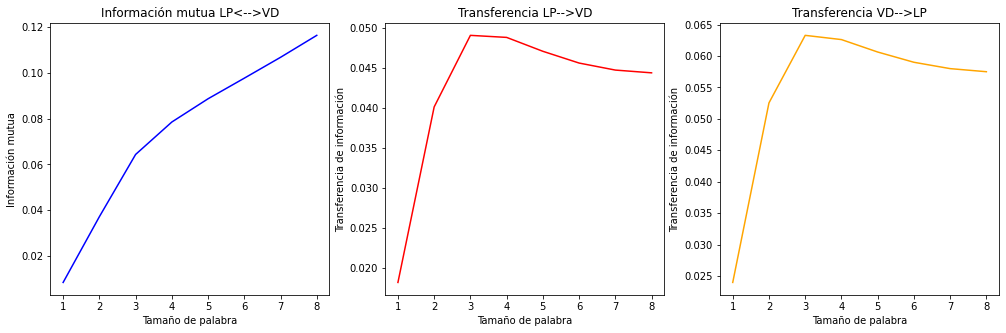

In [46]:
bs = np.arange(1, 9, 1)
Ms_entropy, TXYs, TYXs = compute_info(trozoC_w, bs, "from_entropy", "trozoC")
Ms_direct, _, _ = compute_info(trozoC_w, bs, "direct", "trozoC", verbose = False)

if np.allclose(Ms_entropy, Ms_direct):
        print("Ambas estrategias proporcionan los mismos resultados.")
        
plot_info("trozoC", bs, Ms_entropy, TXYs, TYXs)